In [ ]:
"""big thanks to McKayJohns and mpl soccer

https://www.youtube.com/watch?v=fPcY9dbOMGM&ab_channel=McKayJohns"""

In [1]:
#edit only this tab
#give the folder path of the match
path = "/home/kirugulige/Documents/Football-Analytics/open-data-master/data/events/"
home_team = 'Espanyol'
away_team = 'Barcelona'

In [2]:
import json
import os
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
import StatsbombPitch as sb
from functools import reduce
#from pandas.io.json import json_normalize

Xg_req = pd.DataFrame(data=None)

filename = '69275.json' # remove the comment line to work for this match
with codecs.open("%s" % path + filename,encoding='utf-8') as data_file:   
    data = json.load(data_file)
    df = pd.DataFrame(data=None)
        
    df = pd.json_normalize(data, sep = "_")
        
        #df =  df[(df['type_name'] == "Shot")]
        #df = df.loc[:,['location','shot_body_part_id','shot_end_location','shot_one_on_one','shot_technique_id','shot_type_id','under_pressure','shot_outcome_id']]
        #print(df.shape)
Xg_req = Xg_req.append(df,ignore_index=True,sort=False)
        #df.drop(df.index, inplace=True)
        
print("done")
df = Xg_req

done


In [3]:
df_pass = df[df['type_name']=='Pass']

df_pass = df_pass[['id','minute','second','team_name','location','player_name','pass_recipient_name','pass_end_location','pass_outcome_name' ]]

df_successful_pass = df_pass[df_pass.pass_outcome_name.isna()]

In [4]:
#get substitution value
df_subs = df[df['type_name']=='Substitution'].groupby('team_name',as_index=False).min()#.agg({'minute':['min'],'second':['min']})

df_hsubs = df_subs[df_subs['team_name']== home_team]
home_min =   int(df_hsubs['minute'])
home_sec =   int(df_hsubs['second'])


df_asubs = df_subs[df_subs['team_name']== away_team]
away_min =   int(df_asubs['minute'])
away_sec =   int(df_asubs['second'])


In [5]:
df_home_team = df_successful_pass[df_successful_pass['team_name']==home_team] 

df_home_team = df_home_team[df_home_team['minute'] <= home_min]
df_away_team = df_successful_pass[df_successful_pass['team_name']==away_team]

df_away_team = df_away_team[df_away_team['minute'] <= away_min]

In [6]:
def split_locx(line):
    return line.location[0]


def split_locy(line):
    return line.location[1]

def split_endlocx(line):
    return line.pass_end_location[0]


def split_endlocy(line):
    return line.pass_end_location[1]

In [7]:
def plot(df_away_team):

    df_away_team['loc_x'] = df_away_team.apply(split_locx,axis = 1)
    df_away_team['loc_y'] = df_away_team.apply(split_locy,axis = 1)

    df_away_team['endloc_x'] = df_away_team.apply(split_endlocx,axis = 1)
    df_away_team['endloc_y'] = df_away_team.apply(split_endlocy,axis = 1)

    #get average location
    df_away_avg = df_away_team.groupby('player_name').agg({'loc_x':['mean'],'loc_y':['mean','count']})

    df_away_avg.columns = ['loc_x','loc_y','count']

    df_away_avg

    df_pass_away_between = df_away_team.groupby(['player_name','pass_recipient_name']).id.count().reset_index()
    df_pass_away_between.rename({'id':'pass_count'},axis='columns',inplace=True)

    df_pass_away_between = df_pass_away_between.merge(df_away_avg,left_on ='player_name',right_index=True)
    df_pass_away_between = df_pass_away_between.merge(df_away_avg,left_on ='pass_recipient_name',right_index=True,suffixes=['','_end'])

    df_pass_away_between = df_pass_away_between[df_pass_away_between['pass_count'] >3]
    df_pass_away_between

    from mplsoccer.pitch import Pitch
    from mplsoccer.statsbomb import read_event, EVENT_SLUG
    from matplotlib import rcParams


    pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
                  pitch_color='#22312b', line_color='#c7d5cc', figsize=(16, 11),
                  constrained_layout=False, tight_layout=True)
    fig, ax = pitch.draw()

    #arrows = pitch.arrows(1.2*df_pass_away_between.loc_x,0.8*df_pass_away_between.loc_y,1.2*df_pass_away_between.loc_x_end,0.8*df_pass_away_between.loc_y_end,ax=ax,)

    arrows = pitch.arrows(1.2*df_pass_away_between.loc_x,.8*df_pass_away_between.loc_y,1.2*df_pass_away_between.loc_x_end,.8*df_pass_away_between.loc_y_end,
                         width = 5, headwidth = 5, color = 'r', ax = ax, zorder = 1, alpha = .5)

    nodes = pitch.scatter(1.2*df_away_avg.loc_x,.8*df_away_avg.loc_y,
                         s = 300, color = '#d3d3d3', edgecolors = 'black', linewidth = 2.5, alpha = 1, zorder = 1, ax=ax)


    for index, row in df_pass_away_between.iterrows():
        pitch.annotate(row.player_name, xy=(1.2*row.loc_x,0.8* row.loc_y), c='gray', va='center', ha='center', size=16, weight='bold', ax=ax)
    #title = ax.set_title("{} {} Formation vs {}".format(away_team, '433', home_team), size=28, y=0.97, color='#c7d5cc')
    fig.set_facecolor("#22312b")

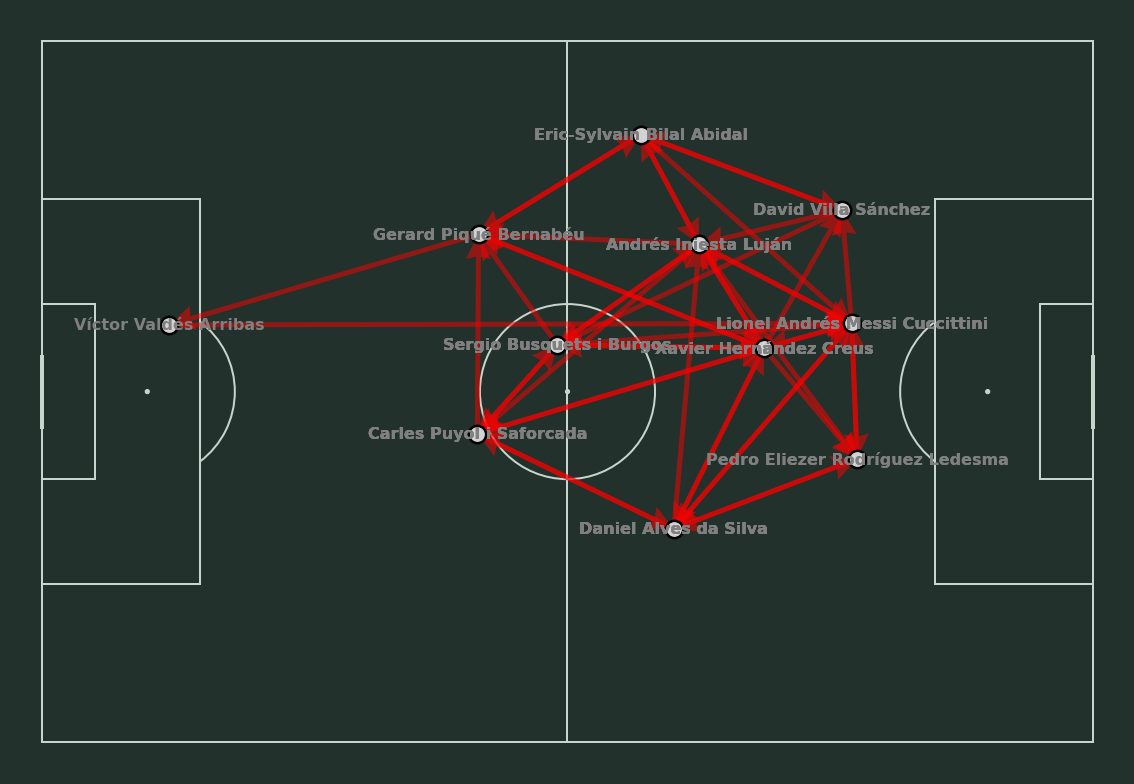

In [8]:
plot(df_away_team)

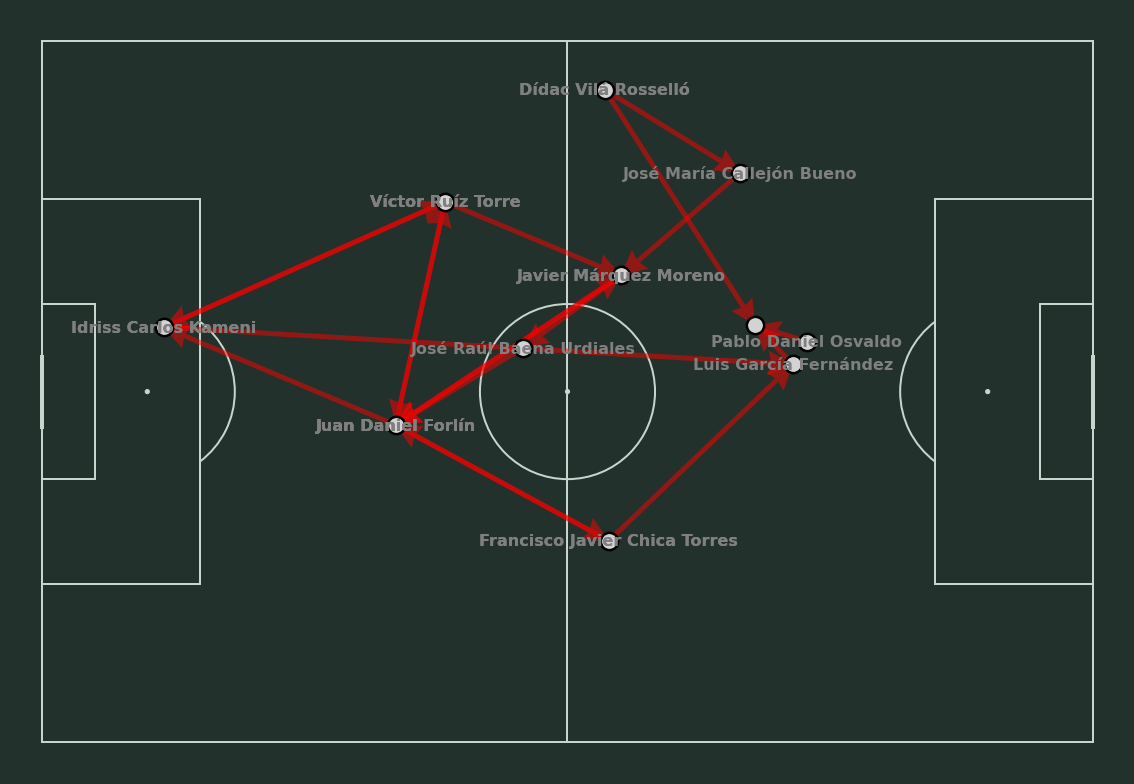

In [9]:
plot(df_home_team)